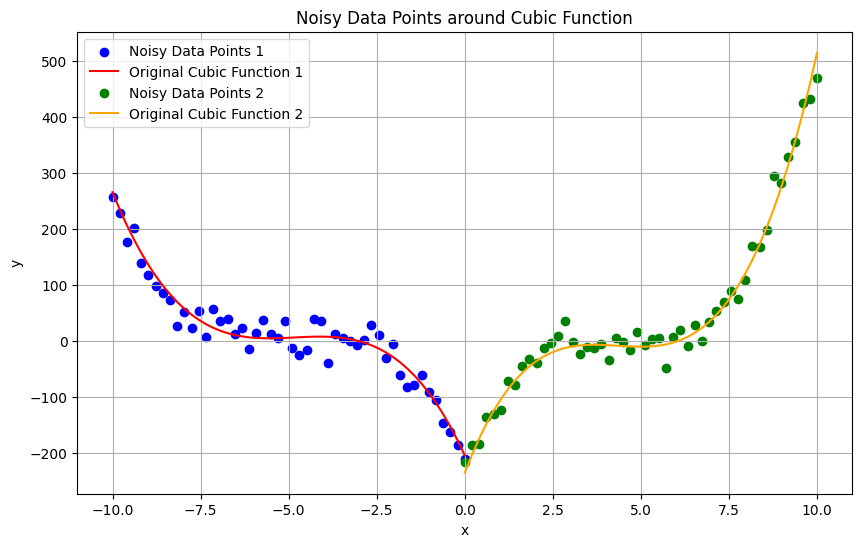

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


def poly1(x):
    return -2*x**3 + x**2 + 3*x + 6

def poly2(x):
    return 3*x**3 + 6*x**2 - 10


def data_generator(data_size=50, noise_std=20.5):
    x1 = torch.linspace(-10, 0, steps=data_size) 
    x2 = torch.linspace(0, 10, steps=data_size)
    y1 = poly1(x1+5)
    y2 = poly2(x2-5)

    noisy_x1 = x1 #+ torch.randn_like(x1) * noise_std
    #noisy_x1 = torch.clamp(noisy_x1, min=-10, max=0)
    noisy_x2 = x2 #+ torch.randn_like(x2) * noise_std
    #noisy_x2 = torch.clamp(noisy_x2, min=0, max=10)
    noisy_y1 = y1 + torch.randn_like(y1) * noise_std
    noisy_y2 = y2 + torch.randn_like(y2) * noise_std


    return noisy_x1, noisy_y1, noisy_x2, noisy_y2, x1, y1, x2, y2

noisy_x1, noisy_y1, noisy_x2, noisy_y2, x1_normal, y1_normal, x2_normal, y2_normal = data_generator()

plt.figure(figsize=(10, 6))

plt.scatter(noisy_x1.numpy(), noisy_y1.numpy(), label='Noisy Data Points 1', color='blue')
plt.plot(x1_normal.numpy(), y1_normal.numpy(), label='Original Cubic Function 1', color='red')
plt.scatter(noisy_x2.numpy(), noisy_y2.numpy(), label='Noisy Data Points 2', color='green')
plt.plot(x2_normal.numpy(), y2_normal.numpy(), label='Original Cubic Function 2', color='orange')

plt.title('Noisy Data Points around Cubic Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

### Understanding Python Array Slicing

In Python, array slicing is a powerful feature for working with sequences like lists, tuples, and arrays. It allows you to efficiently extract subsets of elements from these sequences based on specified indices and step values.

#### Basic Syntax:

- `a[start:stop]`: Selects items from `start` through `stop-1`.
- `a[start:]`: Selects items from `start` through the end of the array.
- `a[:stop]`: Selects items from the beginning through `stop-1`.
- `a[:]`: Makes a copy of the entire array.

#### Using Step Value:

- `a[start:stop:step]`: Selects items from `start` through `stop-1`, skipping `step` elements each time.

#### Negative Indices:

- Negative indices count from the end of the array.
  - `a[-1]`: Last item in the array.
  - `a[-2:]`: Last two items.
  - `a[:-2]`: Everything except the last two items.

#### Reversing:

- `a[::-1]`: Reverses all items in the array.
- `a[1::-1]`: Reverses the first two items.
- `a[:-3:-1]`: Reverses the last two items.
- `a[-3::-1]`: Reverses everything except the last two items.


In [10]:
from torchviz import make_dot
import torch.utils.tensorboard as tb
writer = tb.SummaryWriter()

class LinearRegressionStatic(nn.Module):
    def __init__(self):
        super(LinearRegressionStatic, self).__init__()
        self.hidden1 = nn.Linear(1, 5)
        self.hidden2 = nn.Linear(5, 7)
        self.hidden3 = nn.Linear(7, 10)
        self.hidden4 = nn.Linear(10, 5)
        self.output = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = torch.relu(self.hidden4(x))
        x = self.output(x)
        return x

class DynamicLinearRegression(nn.Module):
    def __init__(self, num_layers, num_nodes):
        super(DynamicLinearRegression, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(num_layers):
            if i == 0:
                self.hidden_layers.append(nn.Linear(1, num_nodes[i]))
            else:
                self.hidden_layers.append(nn.Linear(num_nodes[i-1], num_nodes[i]))
        self.output = nn.Linear(num_nodes[-1], 1)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        x = self.output(x)
        return x

model1 = LinearRegressionStatic()
#model2 = DynamicLinearRegression(4, [5, 7, 10, 5])

predicted_y_model1 = model1(noisy_x1.unsqueeze(1)) 
#predicted_y_model2 = model2(noisy_x1.unsqueeze(1)) 


#Torchviz
make_dot(predicted_y_model1 ,params= dict(model1.named_parameters())).render("test_model1_torchviz", format="png")
#make_dot(predicted_y_model2 ,params= dict(model2.named_parameters())).render("test_model2_torchviz", format="png")

#Tensorboard
writer.add_graph(model1, noisy_x1.unsqueeze(1))
#writer.add_graph(model2, noisy_x1.unsqueeze(1))
writer.close()

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch.utils.tensorboard as tb
import neptune

# run = neptune.init_run(
#     project="tuancao749/DLProject1",
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3NjUyZGRmNi1mYjliLTQ2MjItODcyZS1lMWFkNzdkYWRmMmYifQ==",
# )

writer = tb.SummaryWriter()

def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    num_epochs = 1000
    num_layers = trial.suggest_int('num_layers', 1, 6)
    layer_nodes = [trial.suggest_int(f'layer_{i}_nodes', 1, 10) for i in range(num_layers)]
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # run['Trial_{}/Hyperparameters'.format(study.trials[-1].number)] = {
    #         'Learning Rate': lr,
    #         'Number of Layers': num_layers,
    #         'Layer Nodes': layer_nodes
    #     }
    
    total_loss = 0.0
    for i, (train_index, val_index) in enumerate(kf.split(noisy_x1)):
        train_x, train_y = noisy_x1[train_index], noisy_y1[train_index]
        val_x, val_y = noisy_x1[val_index], noisy_y1[val_index]

        model = DynamicLinearRegression(num_layers, layer_nodes)
        loss_fnc = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(num_epochs):
            outputs = model(train_x.unsqueeze(1))
            loss = loss_fnc(outputs, train_y.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # run[f'Trial_{study.trials[-1].number}/Fold_{i}/Training_Loss'].append(step=epoch, value=loss.item())

        with torch.no_grad():
            val_outputs = model(val_x.unsqueeze(1))
            val_loss = loss_fnc(val_outputs, val_y.unsqueeze(1))
        
        total_loss += val_loss.item()

        # run['Trial_{}/Validation_Loss'.format(study.trials[-1].number)].append(val_loss.item())
        

        #Plot for each Fold
        plt.figure(figsize=(10, 6))
        plt.scatter(train_x.numpy(), train_y.numpy(), label='Noisy train Data Points', color='blue')
        plt.scatter(val_x.numpy(), val_y.numpy(), label='Noisy test Data Points', color='red')
        with torch.no_grad():
            predicted_y = model(noisy_x1.unsqueeze(1)).numpy()
            plt.plot(noisy_x1.numpy(), predicted_y, label='Predicted Function', color='green')
        plt.title(f'Noisy Data Points around Cubic Function, loss = {val_loss.item()}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)
        #plt.savefig(f'img/trial_{study.trials[-1].number}_Fold_{i}.png') 
        fig = plt.gcf()
        plt.close()

        description = f'Trial: {study.trials[-1].number}, Fold: {i}, Loss: {val_loss.item()}'
        # run[f"Trial_{study.trials[-1].number}/Prediction_Examples"].append(value=fig, name=f'Trial_{study.trials[-1].number}_Fold_{i}', description=description, step=int(i))




    return total_loss / 10

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

best_params = study.best_params
best_value = study.best_value

# run['Best_Parameters'] = best_params
# run['Best_Value'] = best_value

# # End Neptune run
# run.stop()

c:\Users\Cao Tuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-05-06 13:39:18,632] A new study created in memory with name: no-name-4f4e7431-d18a-48bd-8693-e3c8498e1285
[I 2024-05-06 13:39:25,388] Trial 0 finished with value: 3036.0613525390627 and parameters: {'lr': 0.0013410669970986787, 'num_layers': 4, 'layer_0_nodes': 1, 'layer_1_nodes': 6, 'layer_2_nodes': 8, 'layer_3_nodes': 2}. Best is trial 0 with value: 3036.0613525390627.
[I 2024-05-06 13:39:32,608] Trial 1 finished with value: 4114.085498046875 and parameters: {'lr': 0.0005144285220162968, 'num_layers': 6, 'layer_0_nodes': 6, 'layer_1_nodes': 8, 'layer_2_nodes': 9, 'layer_3_nodes': 3, 'layer_4_nodes': 1, 'layer_5_nodes': 10}. Best is trial 0 with value: 3036.0613525390627.
[I 2024-05-06 13:39:39,085] T

In [12]:
best_lr = study.best_params['lr']
best_num_layers = study.best_params['num_layers']
best_layer_nodes = [study.best_params[f'layer_{i}_nodes'] for i in range(best_num_layers)]

print(best_lr)
print(best_num_layers)
print(best_layer_nodes)

0.015890283865086167
6
[4, 8, 8, 2, 4, 6]


tensor(778.8408)


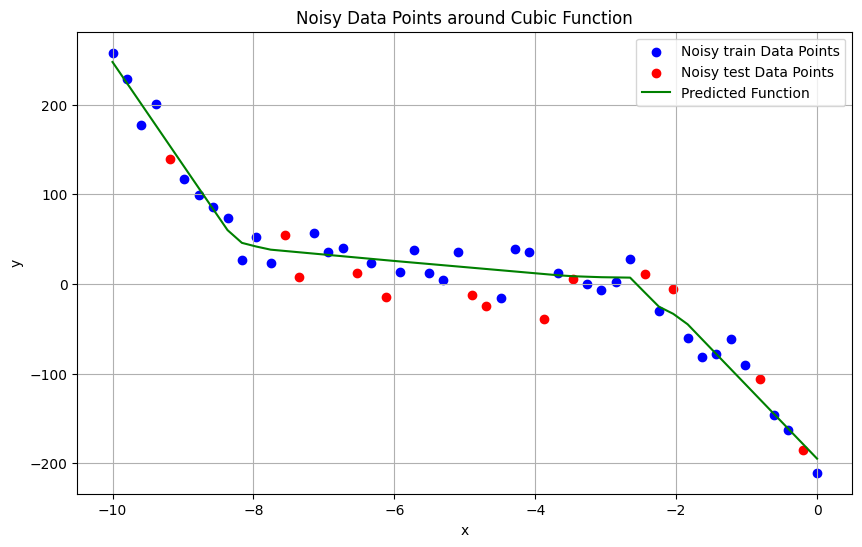

In [21]:
best_lr = study.best_params['lr']
best_num_layers = study.best_params['num_layers']
best_layer_nodes = [study.best_params[f'layer_{i}_nodes'] for i in range(best_num_layers)]

from sklearn.model_selection import train_test_split

import neptune
# model_version = neptune.init_model_version(
#     model="DLPROJ1-MOD",
#     project="tuancao749/DLProject1",
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3NjUyZGRmNi1mYjliLTQ2MjItODcyZS1lMWFkNzdkYWRmMmYifQ==", # your credentials
# )

# model_version["model/parameters"] = best_params

train_x, val_x, train_y, val_y = train_test_split(noisy_x1, noisy_y1, random_state=42)

model = DynamicLinearRegression(best_num_layers, best_layer_nodes)
loss_fnc = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)

for epochs in range(1000):
    outputs = model(train_x.unsqueeze(1))
    loss = loss_fnc(outputs, train_y.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


with torch.no_grad():
    val_outputs = model(val_x.unsqueeze(1))
    val_loss = loss_fnc(val_outputs, val_y.unsqueeze(1))


print(val_loss)
plt.figure(figsize=(10, 6))
plt.scatter(train_x.numpy(), train_y.numpy(), label='Noisy train Data Points', color='blue')
plt.scatter(val_x.numpy(), val_y.numpy(), label='Noisy test Data Points', color='red')
with torch.no_grad():
    predicted_y = model(noisy_x1.unsqueeze(1)).numpy()
    plt.plot(noisy_x1.numpy(), predicted_y, label='Predicted Function', color='green')


plt.title('Noisy Data Points around Cubic Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)

model_information = {
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'lr': best_lr,
    'num_layer': best_num_layers,
    'layer_nodes': best_layer_nodes,
}

torch.save(model_information, "first_half_trained_model.pt")
# model_version.stop()

In [ ]:
# Upload the Model to Neptune

model_version = neptune.init_model_version(
    model="DLPROJ1-MOD",
    project="tuancao749/DLProject1",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3NjUyZGRmNi1mYjliLTQ2MjItODcyZS1lMWFkNzdkYWRmMmYifQ==", # your credentials
)
model_version["model"].upload("best_model.pt")

model_version.stop()


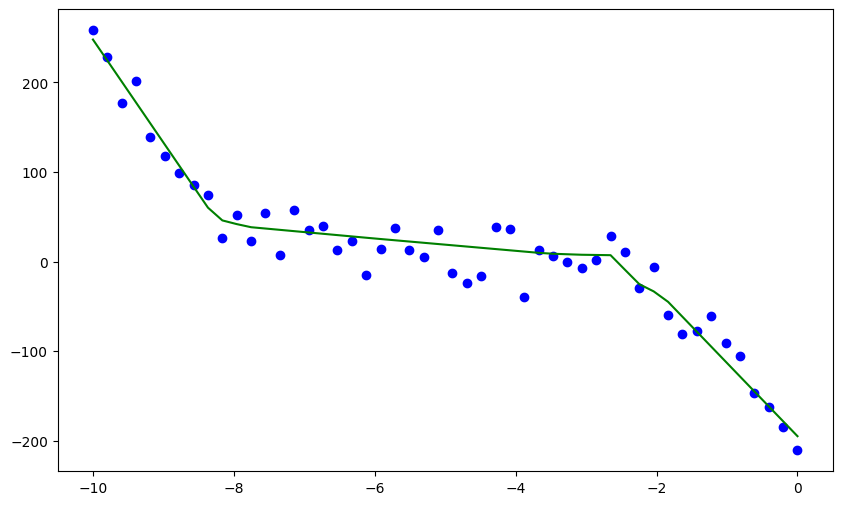

In [38]:
# Load the model and continue training with another data

import torch
from sklearn.model_selection import train_test_split

checkpoint = torch.load("first_half_trained_model.pt")
lr = checkpoint['lr']
num_layers = checkpoint['num_layer']
layer_nodes = checkpoint['layer_nodes']

model = DynamicLinearRegression(num_layers, layer_nodes)
model.load_state_dict(checkpoint['state_dict'])

plt.figure(figsize=(10, 6))
plt.scatter(noisy_x1.numpy(), noisy_y1.numpy(), label='Noisy train Data Points', color='blue')

with torch.no_grad():
    predicted_y1 = model(noisy_x1.unsqueeze(1)).numpy()
    plt.plot(noisy_x1.numpy(), predicted_y1, label='Predicted Function', color='green')

tensor(145.0213)


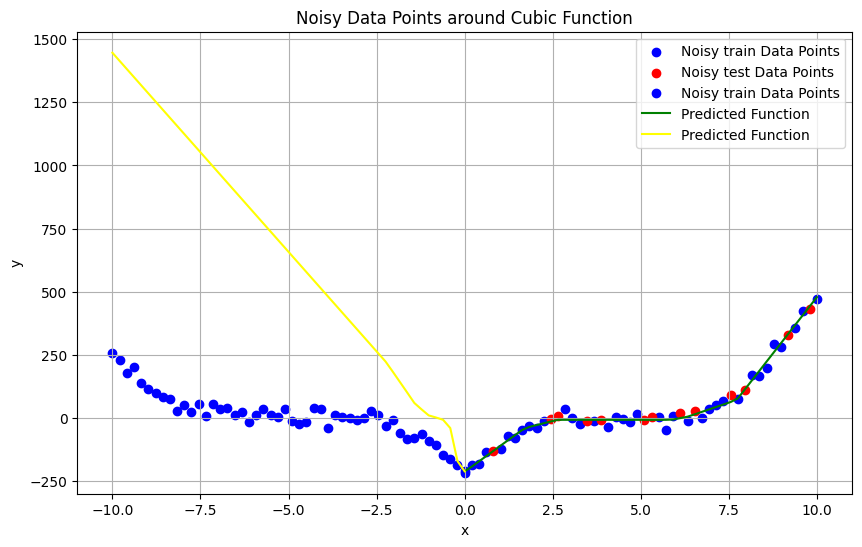

In [35]:
# Load the model and continue training with another data

import torch
from sklearn.model_selection import train_test_split

checkpoint = torch.load("first_half_trained_model.pt")
lr = checkpoint['lr']
num_layers = checkpoint['num_layer']
layer_nodes = checkpoint['layer_nodes']

model = DynamicLinearRegression(num_layers, layer_nodes)
model.load_state_dict(checkpoint['state_dict'])

train_x, val_x, train_y, val_y = train_test_split(noisy_x2, noisy_y2, random_state=42)


loss_fnc = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer.load_state_dict(checkpoint['optimizer'])

for epochs in range(1000):
    outputs = model(train_x.unsqueeze(1))
    loss = loss_fnc(outputs, train_y.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


with torch.no_grad():
    val_outputs = model(val_x.unsqueeze(1))
    val_loss = loss_fnc(val_outputs, val_y.unsqueeze(1))


print(val_loss)
plt.figure(figsize=(10, 6))
plt.scatter(train_x.numpy(), train_y.numpy(), label='Noisy train Data Points', color='blue')
plt.scatter(val_x.numpy(), val_y.numpy(), label='Noisy test Data Points', color='red')
plt.scatter(noisy_x1.numpy(), noisy_y1.numpy(), label='Noisy train Data Points', color='blue')
with torch.no_grad():
    predicted_y2 = model(noisy_x2.unsqueeze(1)).numpy()
    plt.plot(noisy_x2.numpy(), predicted_y2, label='Predicted Function', color='green')
    predicted_y1 = model(noisy_x1.unsqueeze(1)).numpy()
    plt.plot(noisy_x1.numpy(), predicted_y1, label='Predicted Function', color='yellow')


plt.title('Noisy Data Points around Cubic Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
